In [19]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
BASE_DIR = "../audio_dataset"

In [21]:
SR = 16000       
N_MFCC = 40      
MAX_LEN = 300    

def extract_mfcc(file_path, sr=SR, n_mfcc=N_MFCC, max_len=MAX_LEN):
    y, sr = librosa.load(file_path, sr=sr, mono=True)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-9)

    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc


In [22]:
def load_split(split_name):
    X = []
    y = []

    split_dir = os.path.join(BASE_DIR, split_name)
    for label_str in ['0', '1']:
        class_dir = os.path.join(split_dir, label_str)
        label_int = int(label_str)  

        for fname in os.listdir(class_dir):
            if not fname.lower().endswith('.wav'):
                continue
            fpath = os.path.join(class_dir, fname)
            mfcc = extract_mfcc(fpath)
            X.append(mfcc)
            y.append(label_int)

    X = np.array(X)                     
    y = np.array(y)                     
    return X, y

X_train_all, y_train_all = load_split('train')
X_test, y_test = load_split('test')

print("Train all:", X_train_all.shape, y_train_all.shape)
print("Test:", X_test.shape, y_test.shape)


Train all: (2442, 40, 300) (2442,)
Test: (484, 40, 300) (484,)


In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.15,
    stratify=y_train_all,
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)


Train: (2075, 40, 300) (2075,)
Val: (367, 40, 300) (367,)


In [24]:
X_train = X_train[..., np.newaxis]  
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

num_classes = 2
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh  = tf.keras.utils.to_categorical(y_test, num_classes)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.regularizers import l2

input_shape = (N_MFCC, MAX_LEN, 1)

model = Sequential()

model.add(InputLayer(input_shape=input_shape))

# Block 1
model.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

# Dense part
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

d:\Research\emotion_detection_framework\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 40, 300, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 300, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 150, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 150, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 150, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 150, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 37, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 37, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 23680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,062,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,157,442 (23.49 MB)

 Trainable params: 6,156,482 (23.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "voice_model_best.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=1
)


In [10]:
history = model.fit(
    X_train, y_train_oh,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val_oh),
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6710 - loss: 0.9442
Epoch 1: val_accuracy improved from -inf to 0.49864, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.6717 - loss: 0.9425 - val_accuracy: 0.4986 - val_loss: 1.7638
Epoch 2/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7724 - loss: 0.7155
Epoch 2: val_accuracy did not improve from 0.49864
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7726 - loss: 0.7146 - val_accuracy: 0.4986 - val_loss: 2.3769
Epoch 3/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7703 - loss: 0.6694
Epoch 3: val_accuracy did not improve from 0.49864
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7701 - loss: 0.6699 - val_accuracy: 0.4986 - val_loss: 2.3106
Epoch 4/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7743 - loss: 0.6664
Epoch 4: val_accuracy did not improve from 0.49864
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7746 - loss: 0.6652 - val_accuracy: 0.4986 - val_loss: 2.3689
Epoch 5/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7817 - loss: 0.6243
Epoch 5: val_accuracy did not improve fro

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8094 - loss: 0.5515 - val_accuracy: 0.5014 - val_loss: 2.0735
Epoch 8/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8019 - loss: 0.5652
Epoch 8: val_accuracy improved from 0.50136 to 0.50954, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8018 - loss: 0.5654 - val_accuracy: 0.5095 - val_loss: 1.9283
Epoch 9/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8092 - loss: 0.5596
Epoch 9: val_accuracy improved from 0.50954 to 0.51771, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8093 - loss: 0.5593 - val_accuracy: 0.5177 - val_loss: 1.7922
Epoch 10/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8181 - loss: 0.5016
Epoch 10: val_accuracy improved from 0.51771 to 0.54768, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8182 - loss: 0.5018 - val_accuracy: 0.5477 - val_loss: 1.3278
Epoch 11/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8028 - loss: 0.5406
Epoch 11: val_accuracy improved from 0.54768 to 0.57493, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8032 - loss: 0.5402 - val_accuracy: 0.5749 - val_loss: 1.2074
Epoch 12/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8313 - loss: 0.4957
Epoch 12: val_accuracy improved from 0.57493 to 0.64033, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8313 - loss: 0.4954 - val_accuracy: 0.6403 - val_loss: 0.9514
Epoch 13/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8362 - loss: 0.4780
Epoch 13: val_accuracy did not improve from 0.64033
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8362 - loss: 0.4779 - val_accuracy: 0.5995 - val_loss: 1.1493
Epoch 14/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8200 - loss: 0.4860
Epoch 14: val_accuracy improved from 0.64033 to 0.66485, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8203 - loss: 0.4857 - val_accuracy: 0.6649 - val_loss: 0.9915
Epoch 15/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8425 - loss: 0.4608
Epoch 15: val_accuracy did not improve from 0.66485
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8423 - loss: 0.4609 - val_accuracy: 0.6594 - val_loss: 0.8786
Epoch 16/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8182 - loss: 0.4781
Epoch 16: val_accuracy improved from 0.66485 to 0.68120, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8186 - loss: 0.4775 - val_accuracy: 0.6812 - val_loss: 0.7607
Epoch 17/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8319 - loss: 0.4464
Epoch 17: val_accuracy improved from 0.68120 to 0.77929, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8319 - loss: 0.4463 - val_accuracy: 0.7793 - val_loss: 0.5036
Epoch 18/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8312 - loss: 0.4463
Epoch 18: val_accuracy did not improve from 0.77929
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8315 - loss: 0.4459 - val_accuracy: 0.7493 - val_loss: 0.6244
Epoch 19/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8379 - loss: 0.4499
Epoch 19: val_accuracy did not improve from 0.77929
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8383 - loss: 0.4493 - val_accuracy: 0.7684 - val_loss: 0.5958
Epoch 20/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8614 - loss: 0.4109
Epoch 20: val_accuracy did not improve from 0.77929
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8613 - loss: 0.4109 - val_accuracy: 0.7657 - val_loss: 0.5489
Epoch 21/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8693 - loss: 0.3822
Epoch 21: val_accuracy did not impro

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8615 - loss: 0.3785 - val_accuracy: 0.8038 - val_loss: 0.5162
Epoch 28/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8835 - loss: 0.3384
Epoch 28: val_accuracy did not improve from 0.80381
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8834 - loss: 0.3390 - val_accuracy: 0.7956 - val_loss: 0.5040
Epoch 29/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8757 - loss: 0.3829
Epoch 29: val_accuracy improved from 0.80381 to 0.88011, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8757 - loss: 0.3825 - val_accuracy: 0.8801 - val_loss: 0.3410
Epoch 30/50
63/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8837 - loss: 0.3552
Epoch 30: val_accuracy did not improve from 0.88011
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8836 - loss: 0.3550 - val_accuracy: 0.8311 - val_loss: 0.4643
Epoch 31/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8912 - loss: 0.3373
Epoch 31: val_accuracy did not improve from 0.88011
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8910 - loss: 0.3374 - val_accuracy: 0.8392 - val_loss: 0.4179
Epoch 32/50
63/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8839 - loss: 0.3522
Epoch 32: val_accuracy did not improve from 0.88011
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8841 - loss: 0.3519 - val_accuracy: 0.8147 - val_loss: 0.4922
Epoch 33/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8881 - loss: 0.3439
Epoch 33: val_accuracy did not impro

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8997 - loss: 0.3022 - val_accuracy: 0.8883 - val_loss: 0.3289
Epoch 42/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9098 - loss: 0.2846
Epoch 42: val_accuracy did not improve from 0.88828
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9094 - loss: 0.2856 - val_accuracy: 0.8529 - val_loss: 0.3974
Epoch 43/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9099 - loss: 0.2860
Epoch 43: val_accuracy did not improve from 0.88828
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9096 - loss: 0.2863 - val_accuracy: 0.8801 - val_loss: 0.3337
Epoch 44/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9050 - loss: 0.2932
Epoch 44: val_accuracy improved from 0.88828 to 0.90191, saving model to voice_model_best.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9048 - loss: 0.2935 - val_accuracy: 0.9019 - val_loss: 0.3139
Epoch 45/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9028 - loss: 0.2955
Epoch 45: val_accuracy did not improve from 0.90191
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9026 - loss: 0.2957 - val_accuracy: 0.8856 - val_loss: 0.3347
Epoch 46/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9209 - loss: 0.2562
Epoch 46: val_accuracy did not improve from 0.90191
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9207 - loss: 0.2566 - val_accuracy: 0.8283 - val_loss: 0.5427
Epoch 47/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9034 - loss: 0.2964
Epoch 47: val_accuracy did not improve from 0.90191
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9036 - loss: 0.2960 - val_accuracy: 0.8883 - val_loss: 0.3247
Epoch 48/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9047 - loss: 0.2922
Epoch 48: val_accuracy improved from

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9047 - loss: 0.2922 - val_accuracy: 0.9155 - val_loss: 0.2949
Epoch 49/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9134 - loss: 0.2618
Epoch 49: val_accuracy did not improve from 0.91553
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9131 - loss: 0.2623 - val_accuracy: 0.8965 - val_loss: 0.3175
Epoch 50/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9211 - loss: 0.2490
Epoch 50: val_accuracy did not improve from 0.91553
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9210 - loss: 0.2493 - val_accuracy: 0.9074 - val_loss: 0.3111
Restoring model weights from the end of the best epoch: 48.


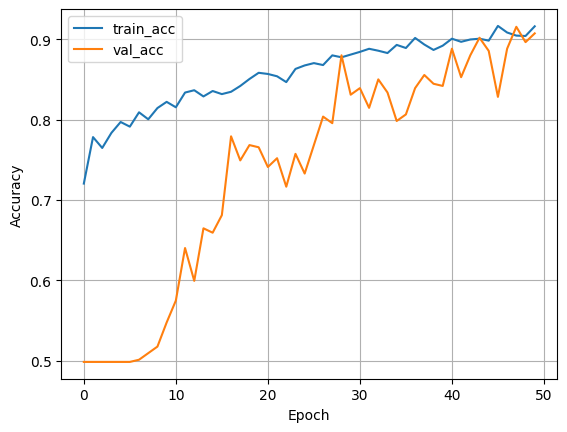

In [11]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('../models/voice_model_best.h5')

test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.8492


In [28]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

print(classification_report(y_test, y_pred, target_names=['happy(0)', 'sad(1)']))
print(confusion_matrix(y_test, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
              precision    recall  f1-score   support

    happy(0)       0.88      0.81      0.84       242
      sad(1)       0.83      0.88      0.85       242

    accuracy                           0.85       484
   macro avg       0.85      0.85      0.85       484
weighted avg       0.85      0.85      0.85       484

[[197  45]
 [ 28 214]]


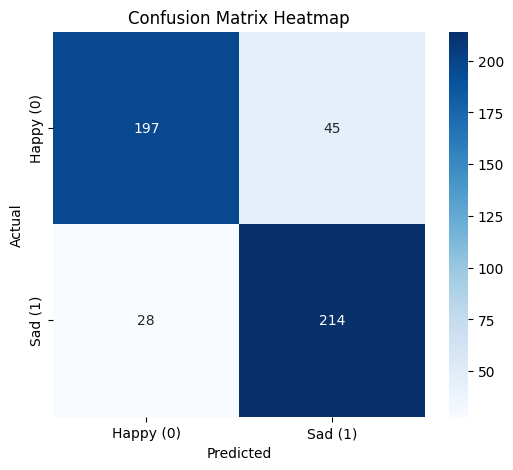

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Happy (0)', 'Sad (1)'],
            yticklabels=['Happy (0)', 'Sad (1)'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()
